### Import Library

In [18]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

### Laod Dataset

In [5]:
train_dir='../datasets/Training'
test_dir='../datasets/Testing'

### Data Understanding

Cek kelas tersedia

In [31]:
classes = os.listdir(train_dir)
print(f"Kelas yang tersedia: {classes}")

Kelas yang tersedia: ['glioma', 'meningioma', 'notumor', 'pituitary']


Buat Dataframe

In [34]:
train_counts = {}
test_counts = {}

for cls in classes:
    train_path = os.path.join(train_dir, cls)
    test_path = os.path.join(test_dir, cls)

    train_counts[cls] = len(os.listdir(train_path))
    test_counts[cls] = len(os.listdir(test_path))
    
df = pd.DataFrame({
    'Class': classes,
    'Train': [train_counts[cls] for cls in classes],
    'Test': [test_counts[cls] for cls in classes]
})

Distribusi Persentase Gamber per Kelas (Train Set)

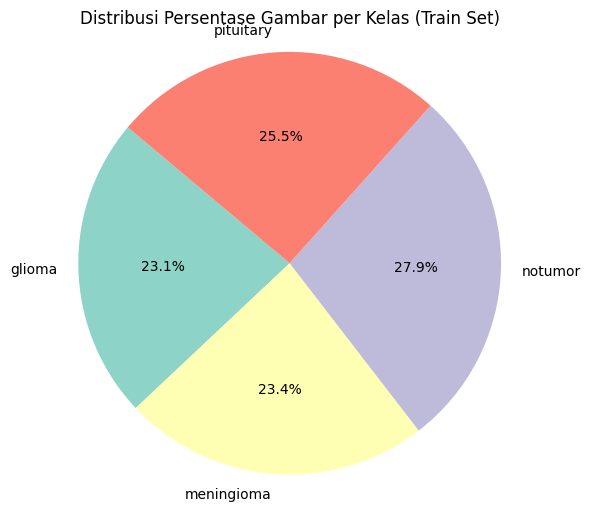

In [35]:
plt.figure(figsize=(6,6))
plt.pie(df['Train'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title("Distribusi Persentase Gambar per Kelas (Train Set)")
plt.axis('equal')
plt.show()

Distribusi Persentase Gambar per Kelas (Test Set)

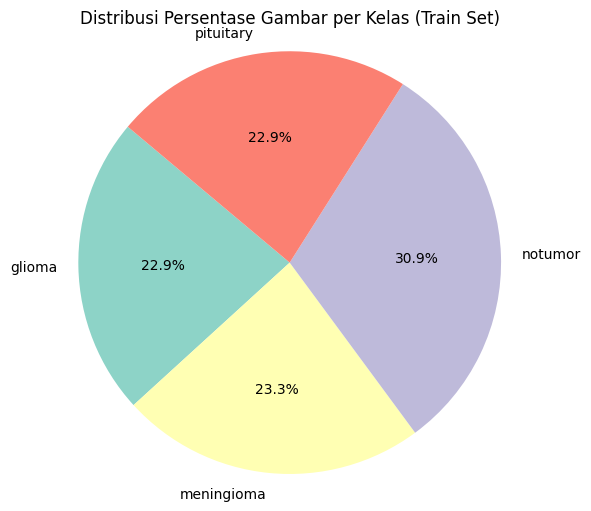

In [36]:
plt.figure(figsize=(6,6))
plt.pie(df['Test'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title("Distribusi Persentase Gambar per Kelas (Train Set)")
plt.axis('equal')
plt.show()

Distribusi Gambar per Kelas (Train vs Test)

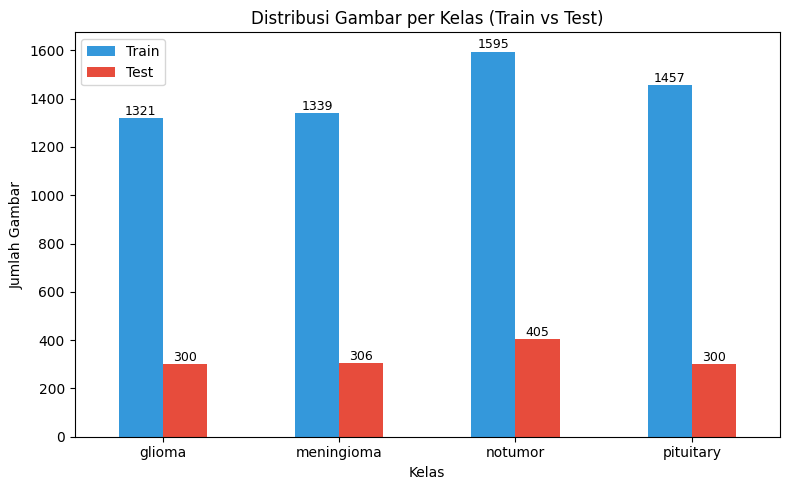

In [38]:
ax = df.set_index('Class')[['Train', 'Test']].plot(
    kind='bar',
    figsize=(8,5),
    color=['#3498db', '#e74c3c']
)

plt.title('Distribusi Gambar per Kelas (Train vs Test)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=0)
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        int(height),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

Visualisasi sample gambar

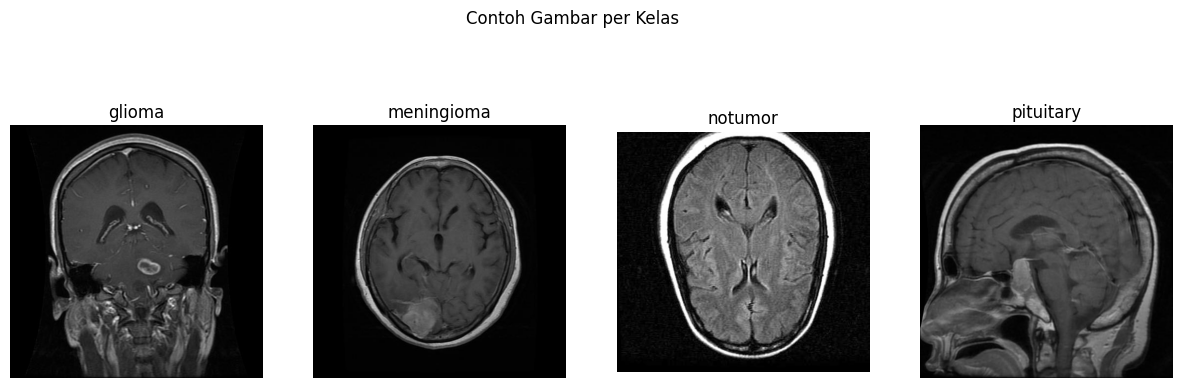

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, cls in enumerate(classes):
    path = os.path.join(train_dir, cls)
    img = random.choice(os.listdir(path))
    img_path = os.path.join(path, img)
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.suptitle("Contoh Gambar per Kelas")
plt.show()

### Data Preprocessing

Image size

In [2]:
img_size = (150, 150)
batch_size = 32

Augmentasi data training

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=(0.85, 1.15),
    width_shift_range=0.002,
    height_shift_range=0.002,
    shear_range=12.5,
    zoom_range=0,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)

Validasi test

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=111
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=111
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### Modeling

Arsitektur model

In [ ]:
model = Sequential([
    Conv2D(32, (4,4), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(pool_size=(4,4)),

    Conv2D(64, (4,4), activation='relu'),
    MaxPooling2D(pool_size=(4,4)),

    Conv2D(128, (4,4), activation='relu'),
    MaxPooling2D(pool_size=(4,4)),
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5, seed=111),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 33, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,700 (912.89 KB)

 Trainable params: 233,700 (912.89 KB)

 Non-trainable params: 0 (0.00 B)

Callback model

In [ ]:
# Callback early stop
early_stop = EarlyStopping(
    monitor='loss', 
    min_delta=1e-9, 
    patience=8, 
    verbose=True
)

# Callback reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=5, 
    verbose=True
)

Training model

In [9]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    validation_steps=178,
    callbacks=[early_stop, reduce_lr]
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.4301 - loss: 1.1628 - val_accuracy: 0.6850 - val_loss: 0.8801 - learning_rate: 0.0010
Epoch 2/30


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 328ms/step - accuracy: 0.7676 - loss: 0.6008 - val_accuracy: 0.7391 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 61s 339ms/step - accuracy: 0.8140 - loss: 0.4782 - val_accuracy: 0.7735 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 62s 344ms/step - accuracy: 0.8486 - loss: 0.3888 - val_accuracy: 0.8314 - val_loss: 0.3907 - learning_rate: 0.0010
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 63s 349ms/step - accuracy: 0.8689 - loss: 0.3536 - val_accuracy: 0.8780 - val_loss: 0.3119 - learning_rate: 0.0010
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 385ms/step - accuracy: 0.8903 - loss: 0.2862 - val_accuracy: 0.8978 - val_loss: 0.2869 - learning_rate: 0.0010
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 62s 347ms/step - accuracy: 0.9027 - loss: 0.2477 - val_accuracy: 0.8940 - val_loss: 0.3241 - learning_rate: 0.0010
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 359ms/step - accuracy: 0.9229 - loss:

### Evaluation

Training dan validasi selama ephocs 

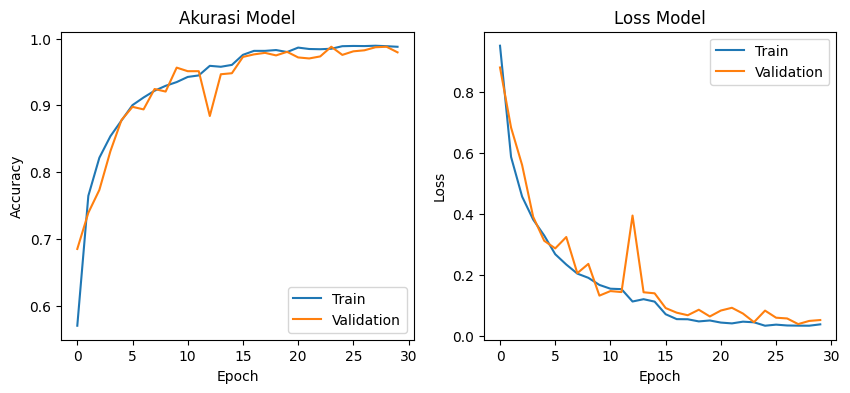

In [10]:
# Plot akurasi
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Persiapan data evaluasi

In [ ]:
# Ambil prediksi
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Ambil label asli
y_true = test_generator.classes

# Ambil nama kelas
class_names = list(test_generator.class_indices.keys())

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step


Classification Report

In [15]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       300
  meningioma       0.97      0.96      0.97       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



Confusion Matrix

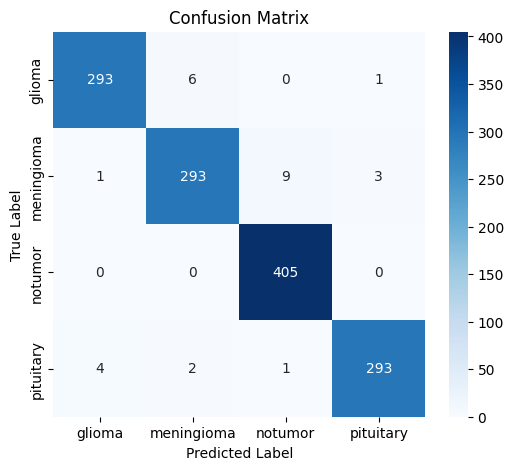

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


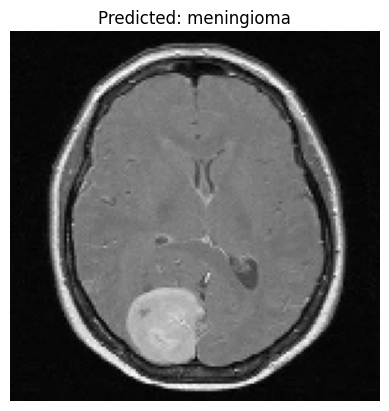

In [27]:
path_glioma = test_dir + "/glioma/Te-gl_0010.jpg"
path_meningioma = test_dir + "/meningioma/Te-me_0010.jpg"
path_pituitary = test_dir + "/pituitary/Te-pi_0010.jpg"
path_notumor = test_dir + "/notumor/Te-no_0010.jpg"

path_test = path_meningioma

class_labels = list(train_generator.class_indices.keys())
sample_img_path = path_test

img = image.load_img(sample_img_path, target_size=img_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


### Model Save

In [26]:
model.save('../output/neuroinsight.h5')